In [1]:
import gym
import numpy as np
import random
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TF to use only the CPU
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

In [2]:
import keras
print("keras:", keras.__version__)

# for building DQN model
import tensorflow as tf
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten, Embedding, Reshape, Input
from keras.models import Model
from keras.optimizers import Adam

keras: 2.11.0


In [3]:
# Data Pre-processing
sales_df = pd.read_csv("train.csv",dtype={'StateHoliday': 'S'})
store_df = pd.read_csv("store.csv")
store_df[['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek']] = store_df[['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek']].astype('Int64', errors='ignore')
store_df['CompetitionOpenSinceMonth'] = store_df['CompetitionOpenSinceMonth'].fillna(12)
store_df['CompetitionOpenSinceYear'] = store_df['CompetitionOpenSinceYear'].fillna(2099)
store_df['Promo2SinceWeek'] = store_df['Promo2SinceWeek'].fillna(51)
store_df['Promo2SinceYear'] = store_df['Promo2SinceYear'].fillna(2099)
df =  pd.merge(sales_df, store_df, how="left", on=["Store"])
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(0)
df['CompetitiondateInt']=df['CompetitionOpenSinceYear'].astype(str) + df['CompetitionOpenSinceMonth'].astype(str).str.zfill(2)+ "01"
df['CompetitionDate'] = pd.to_datetime(df['CompetitiondateInt'], format='%Y%m%d')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['CompetitionDays'] = (df['Date'] - df['CompetitionDate']) / np.timedelta64(1, 'D')
df['CompetitionDays'][df['CompetitionDays'] < 0] = 0
df['Promo2DateInt'] = df.Promo2SinceYear*100+df.Promo2SinceWeek
df['Promo2Date'] = pd.to_datetime(df['Promo2DateInt'].astype(str) + '0', format='%Y%W%w')
df['Promo2Days'] = (df['Date'] - df['Promo2Date']) / np.timedelta64(1, 'D')
df.PromoInterval1 = pd.to_datetime(df.PromoInterval1, format='%b').dt.month
df.PromoInterval2 = pd.to_datetime(df.PromoInterval2, format='%b').dt.month
df.PromoInterval3 = pd.to_datetime(df.PromoInterval3, format='%b').dt.month
df.PromoInterval4 = pd.to_datetime(df.PromoInterval4, format='%b').dt.month
df['Promo2'] = np.logical_or(df['Date'].dt.month==df.PromoInterval1 , np.logical_or(df['Date'].dt.month==df.PromoInterval2 , np.logical_or(df['Date'].dt.month==df.PromoInterval3 , df['Date'].dt.month==df.PromoInterval4)))
df['Promo2'][df['Promo2Days'] < 0] = False
df['Promo2Days'][df['Promo2Days'] < 0] = 0
df['StateHoliday'] = pd.factorize(df['StateHoliday'])[0]
df['StoreType'] = pd.factorize(df['StoreType'])[0] + 1
df['Assortment'] = pd.factorize(df['Assortment'])[0] + 1
df['Promo2'] = pd.factorize(df['Promo2'])[0]
df = df [df['Open'] == 1]
df = df[['Store','Date','DayOfWeek','Promo','Sales']]
df = df.sort_values(by=['Date','Store'])
df.head()

C:\Users\danie\AppData\Local\Temp\ipykernel_21844\2441484184.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CompetitionDays'][df['CompetitionDays'] < 0] = 0
C:\Users\danie\AppData\Local\Temp\ipykernel_21844\2441484184.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Promo2'][df['Promo2Days'] < 0] = False
C:\Users\danie\AppData\Local\Temp\ipykernel_21844\2441484184.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

,Store,Date,DayOfWeek,Promo,Sales
1016179,85,2013-01-01,2,0,4220
1016353,259,2013-01-01,2,0,6851
1016356,262,2013-01-01,2,0,17267
1016368,274,2013-01-01,2,0,3102
1016429,335,2013-01-01,2,0,2401


In [66]:
class Grocery_store (gym.Env):
    # possible actions
    ACTION_LIST = [[0,0], [10000,0],[20000,0],[30000,0],[0,10000]]

    # inventory capacity
    INV_CAP = 40000

    # Pre-order Delay
    PO_DELAY = 5

    # Margin & Cost
    PO_MARGIN = 0.8
    EO_MARGIN = 0.9
    TRANS_COST = 500
    TRANS_MARGIN = 0.03

    # Inventory State Bin Size
    INV_BIN = 10000
    PRE_ORDER_TMR = 15000
    PRE_ORDER_LTR = 15000
    
    # Delivery Schedule
    Delivery_Sch = np.zeros(PO_DELAY)
    
    metadata = {
        "render.modes": ["human"]
        }


    def __init__ (self, df, store_id, strt, end):
        # ACTION SPACE
        self.action_space = gym.spaces.Discrete(5)
        self.observation_space = gym.spaces.MultiDiscrete([self.INV_CAP//self.INV_BIN+1, self.INV_CAP//self.PRE_ORDER_TMR+1] + \
        [self.INV_CAP*(self.PO_DELAY-1)//self.PRE_ORDER_LTR+1] + \
        [8,2])
        # Passive environment
        self.environment = df[df.Store==store_id][['DayOfWeek','Promo']].values
        self.environment = self.environment[strt:end,:]
        self.sales = df[df.Store==store_id]['Sales'].values
        self.sales = self.sales[strt:end]
        
        # Initiate State Information
        self.reset() 

    def reset (self):
        """
        Reset the state of the environment and returns an initial passive environment and inventory.
        Returns
        -------
        State as a tuple of all active and passive envrionment
        """
        # Assuming inventory always start at half of the cap
        self.inventory = self.INV_CAP

        # Delivery Schedule
        self.Delivery_Sch = [0]*self.PO_DELAY
        
        # Reset passive environment to beginning
        self.env_index = 0
        
        # MDP components
        self.state = tuple([self.inventory//self.INV_BIN, self.Delivery_Sch[0]//self.PRE_ORDER_TMR] + \
        [sum(self.Delivery_Sch[1:])//self.PRE_ORDER_LTR] + \
        [self.environment[self.env_index][0],self.environment[self.env_index][1]])
        self.reward = 0
        self.profit = 0
        self.done = False
        self.info = {}
        # Assume all existing inventory at pre-order cost
        self.cost = self.PO_MARGIN
        # Overstock Cost and Order Cost
        self.overstock_cost = 0
        self.order_cost = 0
        self.close_penalty = 0
        return self.state


    def step (self, action):
        """
        The agent takes a step in the environment.
        Parameters
        ----------
        action : Discrete
        Returns
        -------
        state, reward, done, info : tuple
            state (tuple) :
                a tuple of all active and passive envrionment.
            reward (float) :
                immediate profit of the grocery store
            done (bool) :
                whether this is the last period in the time series
            info (dict) :
                 diagnostic information useful for debugging. 
        """
        
        if self.env_index == len(self.environment) - 1:
            self.done = True;

        assert self.action_space.contains(action)
        if action == 0:
            self.order_cost = 0
        else:
            self.order_cost = self.TRANS_COST
        
        if self.sales[self.env_index] >  self.inventory:
            self.close_penalty = 1000
        else:
            self.close_penalty = 0
        # Profit
        # If there's no inventory, the store will be closed. Order cost/Transportation cost is assumed to be accrued at order date
        self.profit = min(self.sales[self.env_index], self.inventory) * (1 - self.cost) - self.order_cost - self.overstock_cost - self.close_penalty
        
        
        order_delivered = self.Delivery_Sch.pop(0)     
        
        # Update cost
        self.cost = (self.inventory * self.cost - min(self.sales[self.env_index], self.inventory) * self.cost +\
                     max(min(self.INV_CAP - (self.inventory - min(self.sales[self.env_index], self.inventory)) - order_delivered, self.ACTION_LIST[action][1]),0) * self.EO_MARGIN +\
                     max(min(self.INV_CAP - (self.inventory - min(self.sales[self.env_index], self.inventory)), order_delivered),0) * self.PO_MARGIN) \
        / max(min(self.inventory - min(self.sales[self.env_index], self.inventory) + self.ACTION_LIST[action][1] + order_delivered, self.INV_CAP), 0.01)
        
        # Reward
        if self.sales[self.env_index] > self.inventory:
            self.reward = 0 # Store closed, no base point
        else:
            self.reward = 10 # Base point for successful run
            
        if self.ACTION_LIST[action][0] > 0:
            self.reward -= 3 # Charge 3 point for regular order cost
        elif self.ACTION_LIST[action][1] > 0:
            self.reward -= 5 # Charge 5 point for emergency order cost
            
        # Update inventory for tomorrow
        # Current Inventory - Item sold in the day + Emergency order + dequeue Pre-order delivered tomorrow
        self.inventory = self.inventory - \
        min(self.sales[self.env_index], self.inventory) + \
        self.ACTION_LIST[action][1] + \
        order_delivered
        

        
        # Update overstock cost
        if self.inventory > self.INV_CAP:
            self.overstock_cost = self.TRANS_COST #inventory exceed limit, excess inventory will be returned at same transportation cost on the next day
            self.inventory = self.INV_CAP
            self.reward -= 4 # Overstock penalty
        else:
            self.overstock_cost = 0
                
        # Update Delivery Queue
        self.Delivery_Sch += [self.ACTION_LIST[action][0]]
        
        # State
        self.state = tuple([self.inventory//self.INV_BIN, self.Delivery_Sch[0]//self.PRE_ORDER_TMR] + \
        [sum(self.Delivery_Sch[1:])//self.PRE_ORDER_LTR]+ \
        [self.environment[self.env_index][0],self.environment[self.env_index][1]])
        
        # Info 
        self.info = {"Inventory":self.inventory,"Schedule": self.Delivery_Sch,"Emerg_Order":self.ACTION_LIST[action][1],"Sales":self.sales[self.env_index],"Cost":self.cost,"Profit":self.profit}

        # Update Index
        self.env_index += 1
        
        try:
            assert self.observation_space.contains(self.state)
        except AssertionError:
            print("INVALID STATE", self.state)
            
        return [self.state, self.reward, self.done, self.info]


    def render (self, mode="human"):
        s = "state: {:2d}  reward: {:2d}  info: {}"
        print(s.format(self.state, self.reward, self.info))


    def close (self):
        pass

In [68]:
env = Grocery_store(df,1007,0,len(df[df.Store==1007])-150)
# env.render()
env_test = Grocery_store(df,1007,len(df[df.Store==1007])-150, len(df[df.Store==1007]))
action_size = env.action_space.n
print('Action Space: ', action_size)

state_size = env.observation_space.shape[0]
print('State Size: ', state_size)

env.environment

Action Space:  5
State Size:  5


array([[3, 0],
       [4, 0],
       [5, 0],
       ...,
       [4, 1],
       [5, 1],
       [6, 0]], dtype=int64)

In [97]:
class DQNAgent:
    def __init__(self, state_size, action_size, dueling=False, DDQN=False):
        self.state_size = state_size
        self.action_size = action_size
        self.dueling = dueling
        self.DDQN = DDQN
        # we keep adding to the list (i.e. replay memory used for training)
        # as soon as we reach 2000, oldest elements are removed (i.e. just use last 2000 memories)
        self.memory = deque(maxlen=10000)
        
        ## begin: hyper parameters
        self.gamma = 0.95 # discount
        self.epsilon = 0.02 # exploration rate
        
        self.epsilon_decay = 0.99 # exploration rate decay
        self.epsilon_min = 0.01 # exploration rate minimum
        
        self.learning_rate = 0.0000001 # for SGD
        ## end
        
        self.model = self._build_model()
        self.model_t = self._build_model_t()
        
    def _build_model(self):
        # NN model to approximate Q-values
        model_input = Input(shape=(self.state_size,))
        
        layer = Dense(128, input_dim = self.state_size, activation='relu')(model_input)
        layer = Dense(32, activation='relu')(layer)
        if self.dueling:
            state = Dense(1, activation='linear')(layer)
            adv = Dense(self.action_size, activation='linear')(layer)
            layer = state + (adv - tf.math.reduce_mean(adv, axis=1, keepdims=True))
        else:
            # Regular DQN Model
            # linear activation: because we are directly modeling the actions 
            # (i.e. value of the actions, so a regression problem), probs etc not needed
            layer = Dense(self.action_size, activation='linear')(layer)
        model = Model(model_input, layer)
        # mse is better choice for loss, e.g. mae performed terribly
        model.compile(loss="mse", optimizer=Adam(lr = self.learning_rate))
        model.summary()
        return model
    
    def _build_model_t(self):
        # NN model to approximate Q-values
        model_input = Input(shape=(self.state_size,))
        
        layer = Dense(128, input_dim = self.state_size, activation='relu')(model_input)
        layer = Dense(32, activation='relu')(layer)
        
        if self.dueling:
            state = Dense(1, activation='linear')(layer)
            adv = Dense(self.action_size, activation='linear')(layer)
            layer = state + (adv - tf.math.reduce_mean(adv, axis=1, keepdims=True))
        else:
            # Regular DQN Model
            # linear activation: because we are directly modeling the actions 
            # (i.e. value of the actions, so a regression problem), probs etc not needed
            layer = Dense(self.action_size, activation='linear')(layer)
        model = Model(model_input, layer)
        # mse is better choice for loss, e.g. mae performed terribly
        model.compile(loss="mse", optimizer=Adam(lr = self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        # exploratory action (i.e. left or right)
        # over time as epsilon decays, model will do more exploitation than exploration 
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        # act_values store q-values, by default list of lists, that is why 0 indexing
        act_values = self.model.predict(state ,verbose=0)
        # print("act_values", act_values)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size, C=10):
        # randomly sample some of our memory at the amount of batch_size
        minibatch = random.sample(self.memory, batch_size)
        episode = 1
        for state, action, reward, next_state, done in minibatch:
            target = reward # this is the case we are done, so collect reward
            
            if not done:
                if self.DDQN: 
                    # if we are not done, use NN to predict future reward
                    # DDQN update
                    target = (reward + self.gamma*self.model_t.predict(next_state,verbose=0)[0][np.argmax(self.model.predict(next_state,verbose=0)[0])])
                else:
                    # DQN & Dueling DDQN update
                    target = (reward + self.gamma*np.amax(self.model_t.predict(next_state,verbose=0)[0]))
            target_f = self.model.predict(state,verbose=0) # our estimated reward at current state
            target_f[0][action] = target # map the value of current state to future state
            
            # single epoch of training with x=state, y=target_f (i.e. predicted future reward)
            # 1 epoch because we only have one single memory to replay here
            self.model.fit(state, target_f, epochs=1, verbose=0)
            if episode % C == 0:
                self.model_t.set_weights(self.model.get_weights()) 
            episode += 1
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def load(self, name):
        self.model.load_weights(name)
    
    def save(self, name):
        self.model.save_weights(name)
            

In [7]:
def train_agent(gAgent, gbatch_size = 500, gn_episodes = 1001):
    done = False # default state is episode not ended

    for e in range(gn_episodes):

        # random starting position at each episode
        state = env.reset()

        # rehape/transpose state vector to fit in the NN
        state = np.reshape(state, [1,state_size])
        # print(state)
        episode_reward = 0
        episode_profit = 0
        # time represents frame of the game; goal is to keep the pole upright as long as possible
        for time in range(5000): 
            # env.render()

            action = gAgent.act(state)

            # print("time: %s action: %s" %(time, action))
            next_state, reward, terminated,  log = env.step(action) # agent interacts with env, gets feedback; 4 state data points
            done = terminated
            reward = reward 
            episode_reward += reward
            episode_profit += log["Profit"]
            next_state =  np.reshape(next_state, [1,state_size])
            gAgent.remember(state, action, reward, next_state, done) # remember previous time steps state, actions, reward
            #print(log,reward)
            state = next_state

            if done: # episode ends if agent drops pole or we reach time step 5000
                # print the episodes score and agent's epsilon
                print("episode: {}/{}, score: {}, e: {:.2}, profit: {}".format(e, gn_episodes, episode_reward, gAgent.epsilon, episode_profit))
                break
        
        # update our \theta (NN model params) at the end of episode
        if len(gAgent.memory) > gbatch_size:
            # train the agent by replaying the experiences of the episode
            gAgent.replay(gbatch_size,20) 

        # every 50th episode, save out model parameters
        # if you did not like model weights at the end of final episode, but liked something in the middle episodes, 
        # you can use those ones
        if e % 10 == 0:
            gAgent.save("model_output/weights_" + '{:04d}'.format(e) + ".hd5")
    return episode_reward

In [93]:
def get_testing_results(gAgent, gn_test_episodes = 10):

    reward = 0
    all_reward = []
    done = False # default state is episode not ended
    for e in range(gn_test_episodes):

        # random starting position at each episode
        state = env_test.reset()
        state = np.reshape(state, [1,state_size])

        episode_reward = []
        acc_reward = 0
        inv = []
        actions = []
        ep_profit = []
        sales = []
        store_close = 0
        overstock = 0
        order = 0
        for time in range(5000): 
            # env.render()

            act_values = gAgent.model.predict(state,verbose=0)
            # print("act_values", act_values)
            action = np.argmax(act_values[0])
            if action > 0:
                order += 1
            # print("time: %s action: %s" %(time, action))
            next_state, reward, terminated,  log = env_test.step(action) # agent interacts with env, gets feedback; 4 state data points
            print(log)
            done = terminated
            reward = reward # reward +1 for each additional frame with pole upright
            inv += [log['Inventory']]
            sales += [log['Sales']]
            if log['Inventory'] == 40000:
                overstock += 1
            if log['Inventory'] < log['Sales']:
                store_close += 1
            acc_reward += reward
            episode_reward += [acc_reward]
            actions += [action]
            next_state =  np.reshape(next_state, [1,state_size])
            state = next_state
            ep_profit += [log['Profit']]
            if done: # episode ends if agent drops pole or we reach time step 5000
                # print the episodes score and agent's epsilon
                print("episode: {}/{}, score: {}, e: {:.2}".format(e, gn_test_episodes, episode_reward, gAgent.epsilon))
                break


    return ep_profit,sales,inv,actions,store_close,overstock,order

In [18]:
def train_test_DDQN_grocery(num_training_episodes, num_test_episodes):
    # num of games (n_episodes) played provides data for training deep RL agent
    # in each episode we remember some events happened in the episode, and use that memory for training purposes
    agent = DQNAgent(state_size, action_size,False,True)
    agent.load("model_output/weights_" + '{:04d}'.format(190) + ".hd5")
    batch_size = 64 # hyperparameter for SGD, tunable
    #last_training_reward = train_agent(agent, gbatch_size = batch_size, gn_episodes = num_training_episodes)
    all_test_reward = get_testing_results(agent, gn_test_episodes = num_test_episodes)
    plt.plot(all_test_reward)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.savefig("Grocery_DDQN.png")
    avg_test_reward = sum(all_test_reward)/num_test_episodes
    return last_training_reward, avg_test_reward

In [96]:
def train_test_DQN_grocery(num_training_episodes, num_test_episodes):
    # num of games (n_episodes) played provides data for training deep RL agent
    # in each episode we remember some events happened in the episode, and use that memory for training purposes
    agent = DQNAgent(state_size, action_size,False,False)
    #agent.load("model_output/weights_" + '{:04d}'.format(140) + ".hd5")
    batch_size = 256 # hyperparameter for SGD, tunable
    last_training_reward = train_agent(agent, gbatch_size = batch_size, gn_episodes = num_training_episodes)
    profit,sales,inv,cost,store_close,overstock,order = get_testing_results(agent, gn_test_episodes = num_test_episodes)
    plt.plot(profit)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.savefig("Grocery_Dueling.png")
    return profit,sales,inv,cost,store_close,overstock,order
    

In [47]:
def train_test_DuelingDDQN_grocery(num_training_episodes, num_test_episodes):
    # num of games (n_episodes) played provides data for training deep RL agent
    # in each episode we remember some events happened in the episode, and use that memory for training purposes
    agent = DQNAgent(state_size, action_size, True,False)
    agent.load("model_output/weights_" + '{:04d}'.format(60) + ".hd5")
    batch_size = 64 # hyperparameter for SGD, tunable
    #last_training_reward = train_agent(agent, gbatch_size = batch_size, gn_episodes = num_training_episodes)
    all_test_reward,_,_ = get_testing_results(agent, gn_test_episodes = num_test_episodes)
    plt.plot(all_test_reward)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.savefig("Grocery_Dueling.png")
    return all_test_reward
    

Model: "model_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_69 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_228 (Dense)           (None, 128)               768       
                                                                 
 dense_229 (Dense)           (None, 32)                4128      
                                                                 
 dense_230 (Dense)           (None, 5)                 165       
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________
{'Inventory': 30704, 'Schedule': [0, 0, 0, 0, 0], 'Emerg_Order': 0, 'Sales': 9296, 'Cost': 0.8, 'Profit': 1859.1999999999996}
{'Inventory': 23231, 'Schedule': [0, 0, 0, 0, 0], 'Emerg_Order

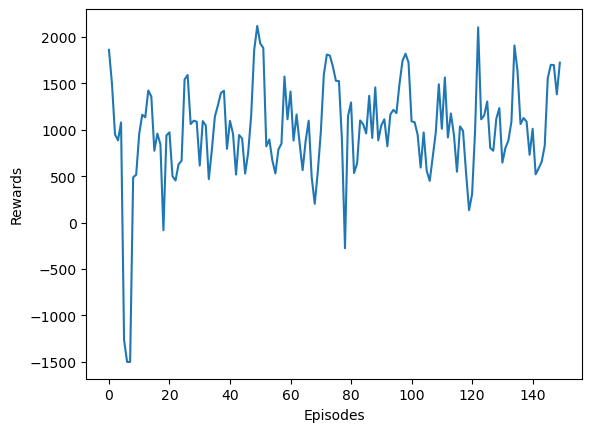

In [94]:
profit,sales,inv,cost,store_closure,overstock,order = train_test_DQN_grocery(150, 1)
print(sum(profit),store_closure,overstock,order)

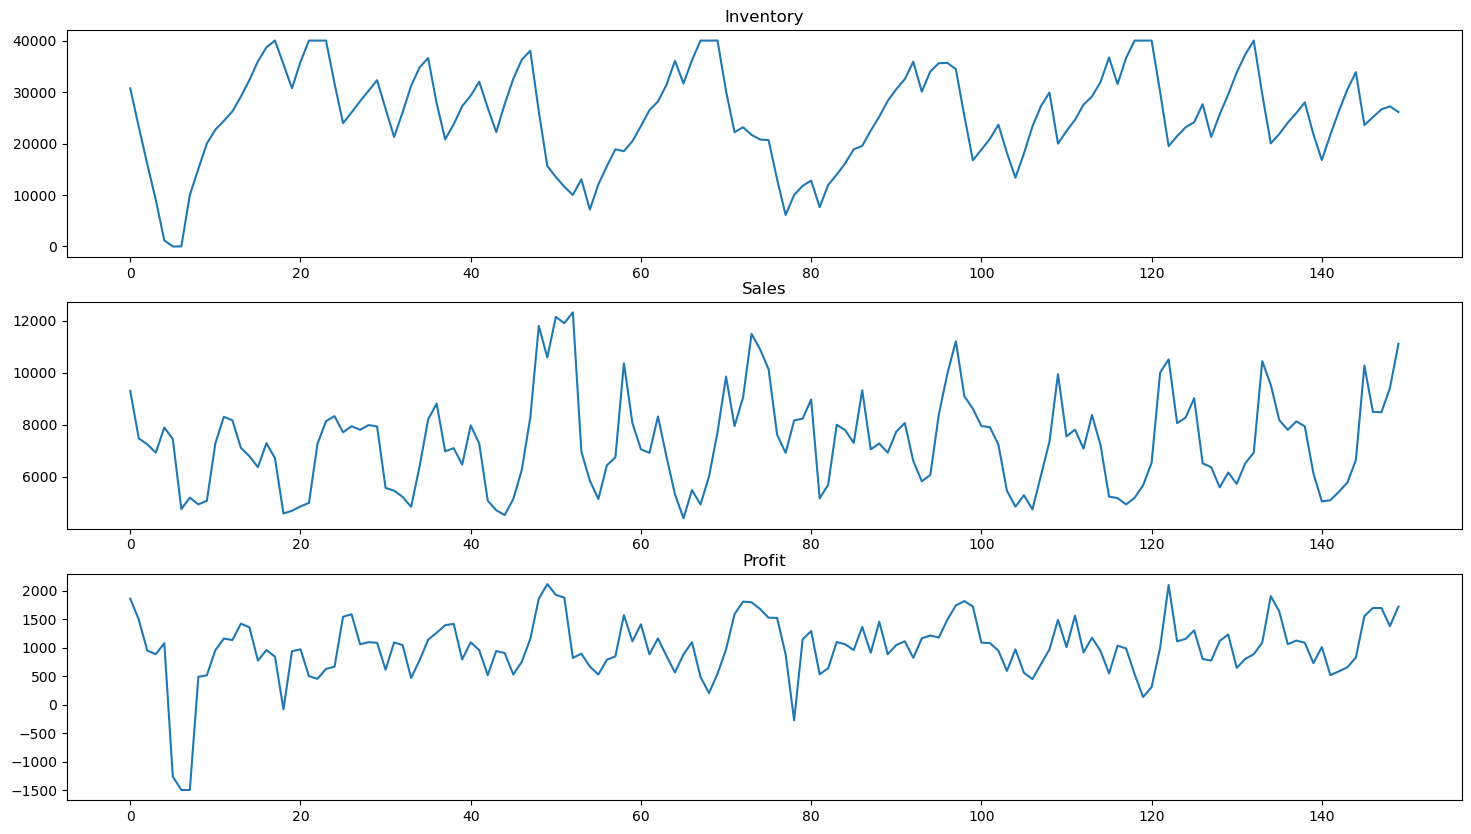

In [82]:
fig, ax = plt.subplots(3,1,figsize=(18,10))
ax[0].plot(inv,label='Inventory')
ax[1].plot(sales,label='Sales')
ax[2].plot(profit,label='Profit')
ax[0].title.set_text('Inventory')
ax[1].title.set_text('Sales')
ax[2].title.set_text('Profit')
plt.savefig('reinforcement.png')